In [2]:
#importing all necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.cluster import KMeans

#load csv file with the correct delimiter 
file_path = 'malware-capture-csv/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv'
data = pd.read_csv(file_path, delimiter='|')



/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_24309/1386953590.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.replace('-', np.nan, inplace=True)
/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_24309/1386953590.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_selected.loc[:, 'duration'].fillna

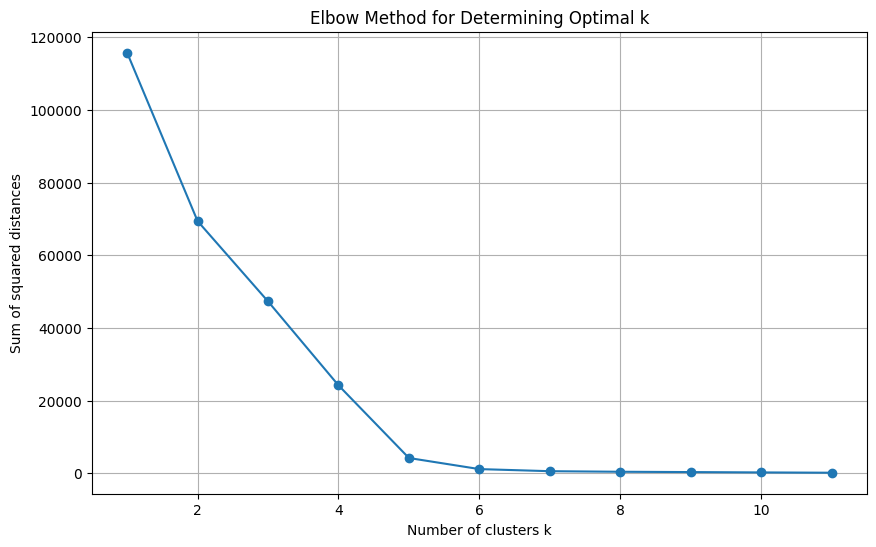

In [13]:
# Select relevant columns
selected_columns = [
    'ts', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 
    'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'label', 'orig_pkts'
]
data_selected = data[selected_columns]

# Data Cleaning
data_selected.replace('-', np.nan, inplace=True)
data_selected.loc[:, 'duration'] = pd.to_numeric(data_selected.loc[:, 'duration'], errors='coerce')
data_selected.loc[:, 'orig_bytes'] = pd.to_numeric(data_selected.loc[:, 'orig_bytes'], errors='coerce')
data_selected.loc[:, 'resp_bytes'] = pd.to_numeric(data_selected.loc[:, 'resp_bytes'], errors='coerce')

# Fill missing values
data_selected.loc[:, 'duration'].fillna(data_selected['duration'].median(), inplace=True)
data_selected.loc[:, 'orig_bytes'].fillna(0, inplace=True)
data_selected.loc[:, 'resp_bytes'].fillna(0, inplace=True)

data_selected.loc[:, 'date'] = pd.to_datetime(data_selected.loc[:, 'ts'], unit='s').dt.date


# One-hot encode 'proto'
encoder = OneHotEncoder()
proto_encoded = encoder.fit_transform(data_selected[['proto']]).toarray()  # Convert sparse matrix to dense matrix

#==================================================================================================================================================
#==================================================================================================================================================
##### OMG NEW FEATURE DOMAIN SPECIFIC INTERACTION 
# Calculate bytes per second for better granularity in traffic analysis
data_selected['bytes_per_second'] = data_selected['orig_bytes'] / data_selected['duration']

# Calculate packets per second to capture activity rate
data_selected['packets_per_second'] = data_selected['orig_pkts'] / data_selected['duration']

# Calculate time since last communication to identify regular patterns
data_selected.sort_values('ts', inplace=True)
data_selected['last_communication'] = data_selected.groupby(['id.orig_h', 'id.resp_h'])['ts'].shift(1)
data_selected['time_since_last_comm'] = data_selected['ts'] - data_selected['last_communication']

# Count daily communications to detect frequent interactions typical for C&C
data_selected['date'] = pd.to_datetime(data_selected['ts'], unit='s').dt.date
daily_communication = data_selected.groupby(['id.orig_h', 'id.resp_h', 'date']).size().reset_index(name='daily_communications')
data_selected = data_selected.merge(daily_communication, on=['id.orig_h', 'id.resp_h', 'date'], how='left')

#==================================================================================================================================================
#==================================================================================================================================================

# Combine the encoded proto data with other numerical features
features = np.hstack((data_selected[['duration', 'orig_bytes', 'resp_bytes']].values, proto_encoded))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
sse = []
k_list = range(1, 12)  # Check from 1 to 10 clusters
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

# Plot the SSE values for each k
plt.figure(figsize=(10, 6))
plt.plot(k_list, sse, marker='o')
plt.title('Elbow Method for Determining Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()



## Cluster Analysis
### Cluster 0: Represents the majority of the data points.
- Average Duration: Approximately 8.10 seconds
- Average Originating Bytes: About 6.58 bytes
- Average Responding Bytes: About 85.13 bytes
- Common Ports: Average originating port around 60,774 and responding port around 2,512
- Connection States: Primarily consists of 'OTH' (Other), 'S0' (Connection attempt seen, no reply), and 'S3' states.
- Protocols: Exclusively 'tcp'.

### Cluster 1: Smaller group with distinct characteristics.
- Average Duration: Approximately 2.19 seconds
- Average Originating Bytes: About 1,656.67 bytes (much higher than Cluster 0)
- Average Responding Bytes: About 26.84 bytes (lower than Cluster 0)
- Common Ports: Average originating port around 5,062 and responding port around 116 (indicating potentially different types of traffic or services)
- Connection States: Mainly 'S0' and 'SF' (Normal establishment and termination).
- Protocols: Exclusively 'udp'.

### Cluster 2: Likely an outlier given it contains only one data point.
- Duration: 24.13 seconds (longest among the clusters)
- Originating Bytes: Extremely high at over 75 million bytes
- Responding Bytes: 0 bytes (suggests a one-sided communication or data transfer)
- Connection States: Contains only one 'S0' state.
- Protocols: Exclusively 'udp'.


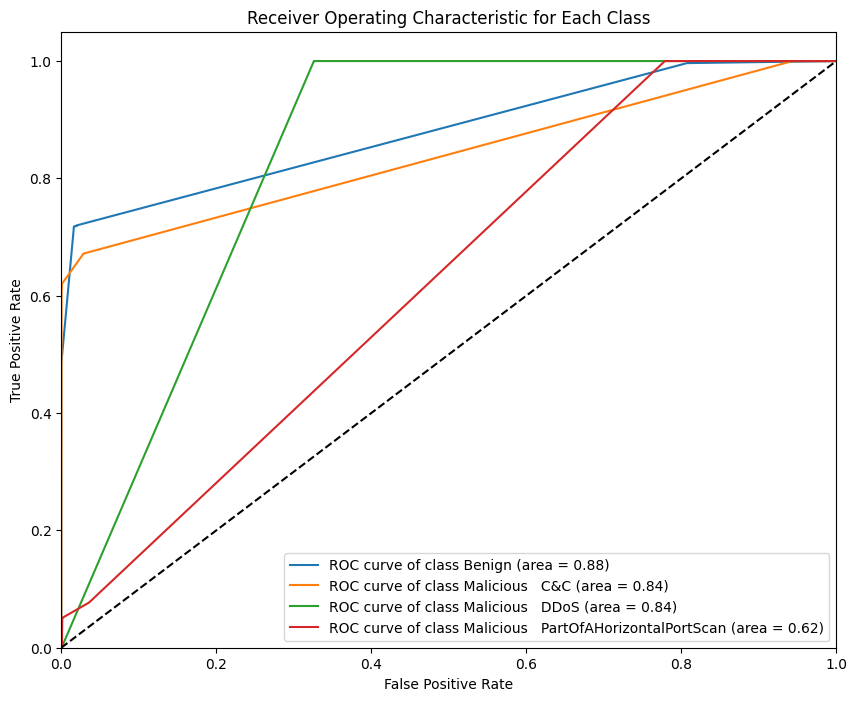

In [14]:
# K-means clustering (use elbow method results to pick k)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)
data_selected['cluster'] = cluster_labels

# Supervised Learning Preparation
label_encoder = LabelEncoder()
data_selected['label_encoded'] = label_encoder.fit_transform(data_selected['label'])
X = features_scaled  # Features already scaled
y = data_selected['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# Evaluation on Accuracy 
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# ROC Curve
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_pred_proba = rf_classifier.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Predict on the test set and evaluate the model
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8607430875576036
Confusion Matrix:
 [[ 415    4  160    0]
 [ 102 1246  659    1]
 [   0    0 4316    2]
 [   1    1   37    0]]
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       579
           1       1.00      0.62      0.76      2008
           2       0.83      1.00      0.91      4318
           3       0.00      0.00      0.00        39

    accuracy                           0.86      6944
   macro avg       0.66      0.58      0.61      6944
weighted avg       0.87      0.86      0.85      6944



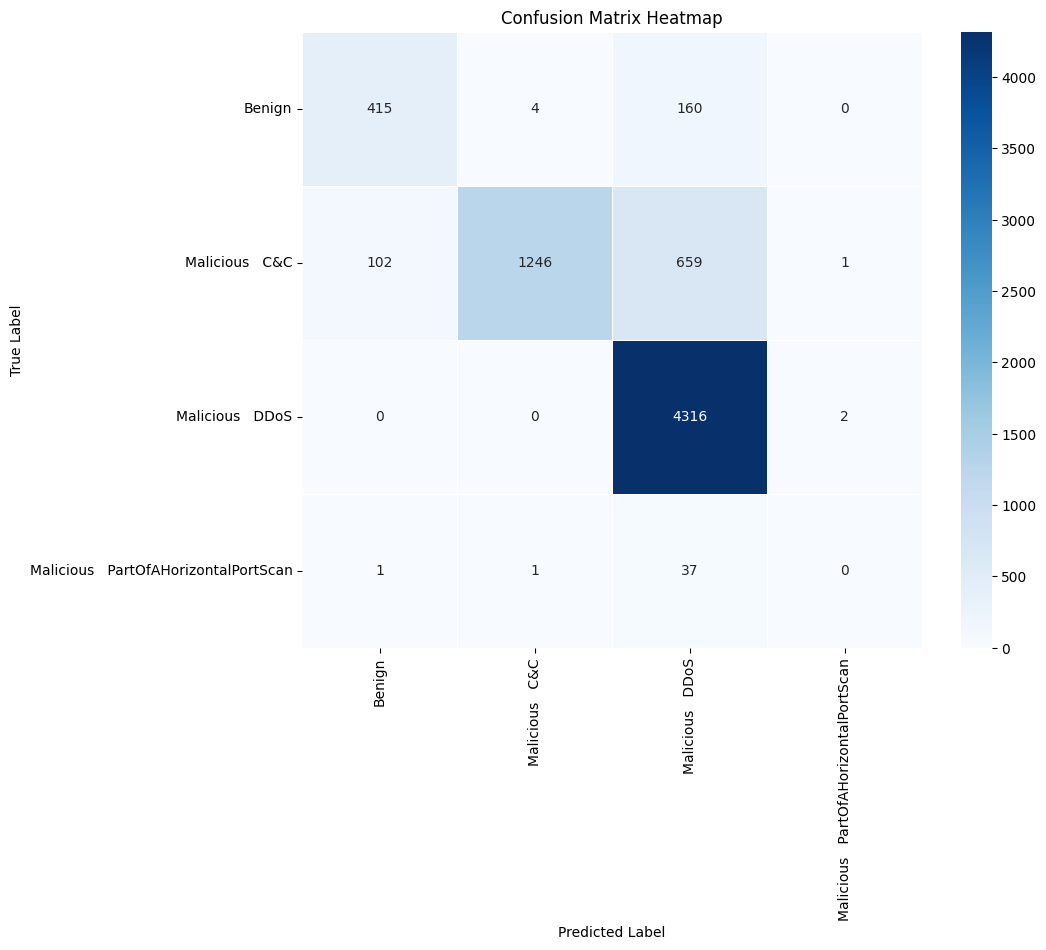

In [12]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()